## 環境設定


In [1]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
import daft
import seaborn as sns
from matplotlib import rc
%matplotlib inline

rc("font", family="serif", size=12)
rc("text", usetex=False)

# 入力セルを非表示にするためのメソッド
# 参照 https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
def hideInputCell():
    return HTML('''<script>
        var code_show=true; 
        function code_toggle() {
            if (code_show){
                $('div.cell.code_cell.rendered.selected div.input').hide();
            } else {
                $('div.cell.code_cell.rendered.selected div.input').show();
            }
            code_show = !code_show
        } 

        $( document ).ready(code_toggle);
        </script>
        To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')


## Variational Auto Encoder
### 導入
Variational Auto Encoder(VAE)では、以下の図のようなグラフィカルモデルで表現された生成過程を利用します。

xは独立同分布な観測データ、各xに対して潜在変数zが1つ存在し、$\theta$は、z, xに共通した潜在変数で、
以下のように生成されます。

- $z^{(i)}$は、事前確率分布 $p(z; \theta)$からサンプリングされる
- $x^{(i)}$は、$p(x^{(i)} | z^{(i)}; \theta)$からサンプリングされる

通常、学習用データxから以下の周辺尤度を最大化することで、潜在変数を推定します。

$$
p(x; \theta) = \int p(x | z; \theta) p(z; \theta) dz
$$

VAEでは、推定が困難な$p(z|x; \theta)$の近似として$q(z | x; \phi)$を導入し、
$KL(q(z|x) || p(z|x))$の関係式を得る。
$$
log p(x) \ge \int q(z|x) log p(x|z)dz - KL(q(z|x) || p(z)) = L(\theta; \phi; x)
$$

ここでのポイントは、$L(\theta; \phi; x)$には事後分布$p(z|x)$を含まないことです。

VAEでは、$L(\theta; \phi; x)$の第1項の期待値計算をサンプリング近似で求め、
$KL(q(z|x)||p(z))$には、解析可能な分布を使用します。

式の導出は、http://nzw0301.github.io/notes/vae.pdf を参照しました。


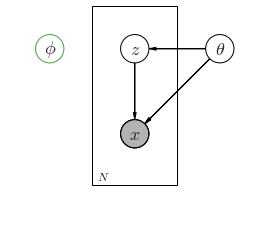

In [2]:
from IPython.display import HTML

# Colors.
p_color = {"ec": "#46a546"}

# Instantiate the PGM. 原点は左下
pgm = daft.PGM([3, 2.5], origin=[0, 0], grid_unit=3,
                   label_params={'fontsize':18})

# Hierarchical parameters.
pgm.add_node(daft.Node("phi", r"$\phi$", 0.5, 2, plot_params=p_color))
pgm.add_node(daft.Node("theta", r"$\theta$", 2.5, 2))

# Latent variable.
pgm.add_node(daft.Node("z", r"$z$", 1.5, 2))

# Data.
pgm.add_node(daft.Node("x", r"$x$", 1.5, 1, observed=True))

# Add in the edges.
# pgm.add_edge("phi", "z")
pgm.add_edge("theta", "z")
pgm.add_edge("theta", "x")
pgm.add_edge("theta", "x")
pgm.add_edge("z", "x")


# And a plate.
pgm.add_plate(daft.Plate([1, 0.5, 1, 2], label=r"$N$",
    shift=-0.1))

# Render and save.
pgm.render()
plt.show()

# 入力セルを非表示にする
hideInputCell()


## ニューラルネットによるVAEの実装
ニューラルネットでのVAEの実装では、観測データxから潜在変数zを求めるencoderと潜在変数zから観測データを復元する　decoderから構成されます。

- encoder : $q(z|x; \phi)$
- decoder : $p(x|z; \theta)$

### encoder
encoderの損失関数は、$KL(q(z|x)||p(z))$のKL項です。
- 事前分布$p(z; \theta)$ : 平均ベクトル 0 ，共分散行列 I の多変量正規分布 $\mathrm{N}_0 (z; 0, I )$ と仮定すると事後分布$p(z|x)$も多変量正規分となります
- $q(z|x; \theta)$ : 平均$\mu$、分散$\Sigma$の多変量正規分布$\mathrm{N}_1 (z; 0, I )$ とします

損失関数としての$KL(q(z|x)||p(z))$は、以下のように求まります。
$$
\begin{eqnarray}
    KL(\mathrm{N}_0 || \mathrm{N}_1) & =  & \frac{1}{2} \left (  tr(\Sigma_1^{-1} \Sigma_0) + (\mu_1 - \mu_0)^T \Sigma_1^{-1} (\mu1 - \mu_0) -k + log_e\frac{| \Sigma_1 |}{| \Sigma_0 |}\right ) \\
    & = & \frac{1}{2} \left ( tr (\Sigma_0) + \mu_0^T \mu_0 -k -log_e | \Sigma_0 | ) \right )
\end{eqnarray}
$$

式の導出は、http://sucrose.hatenablog.com/entry/2013/07/20/190146 を参照しました。

### decoder
平均$\mu$、分散$\Sigma$のサンプリングから入力データXを復元すると、Encorder(Q)とDecorder(P)の計算グラフが途切れてしまうため、
以下の関数を導入して、関数から決定的にzを生成する。これをreparametarization trickと呼ぶ。

$$
z = g(\epsilon^i, x^i; \phi) = \mu + \Sigma^{\frac{1}{2}} \odot \epsilon
$$

PRMLの11章では、Box-Muller法からコレスキー分解(Cholesky decomposition)を使って 分散$\Sigma = L L^T$となるLを求めてｙをサンプリングする手法が紹介されている。

$$
y = \mu + \mathrm{L} z
$$

損失関数は、ロジスティックシグモイド関数なので、binary cross entropyを使用します。

## データのダウンロード
MNISTのデータをkerasのサイトからダウンロードします。

In [3]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print x_train.shape
print x_test.shape

Using TensorFlow backend.


(60000, 784)
(10000, 784)


In [171]:
batch_size = 100
original_dim = 28*28
latent_dim = 5
intermediate_dim = 128
epochs = 10
epsilon_std = 1.0

In [5]:
from keras.layers import Input, Dense, Lambda, concatenate
from keras.models import Model
from keras import metrics
from keras import backend as K

### encodingの実装
encodingの実装は、通常のkerasのSequenceを使ったレイヤーの積み重ねではなくアクティベーション層を平均、log分散の計算に使用するため、KerasのAPIを使ってモデルを構築します。



In [14]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [32]:
def normal_sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [33]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(normal_sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [34]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [35]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [36]:
history = vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
16100/60000 [=======>......................] - ETA: 8s - loss: 223.4908

KeyboardInterrupt: 

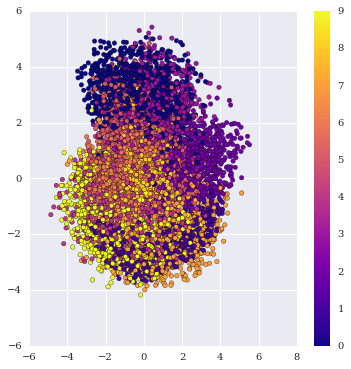

In [77]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap="plasma")
plt.colorbar()
plt.show()

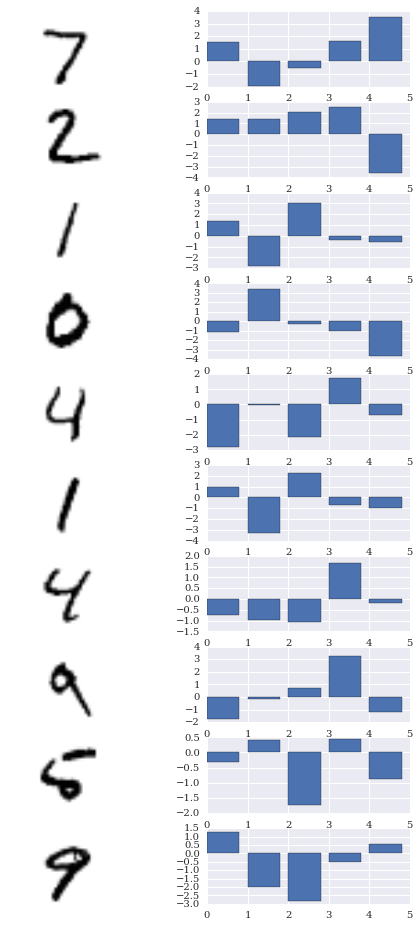

In [78]:

plt.figure(figsize=(8, 16))

n = 10
im_index = 1
indies = range(latent_dim)

for i in range(0, n):
    plt.subplot(n, 2, im_index)
    plt.axis('off')
    plt.imshow(x_test[i].reshape((28,28)))
    im_index += 1

    plt.subplot(n, 2, im_index)
    ax = plt.bar(indies, x_test_encoded[i])
    im_index += 1
plt.show()

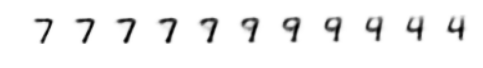

In [79]:
z_7 = x_test_encoded[0]
z_4 = x_test_encoded[4]

plt.figure(figsize=(8, 8))
n = 1
for i in np.arange(0.0, 1.1, 0.1):
    plt.subplot(1, 11, n); n += 1; plt.axis('off')
    # 中間の画像を生成
    z_sample = (1 - i)*z_7 + i*z_4
    img = generator.predict(np.array([z_sample]))
    plt.imshow(img.reshape((28,28)))
plt.show()

## カテゴリカルVAE


In [172]:
categorical_dim = 10
EPSILON = 1e-8

In [173]:
# encoding
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
c_pi = Dense(categorical_dim, activation='softmax')(h)

In [174]:
# カテゴリカルサンプリング関数
def categorical_sample(pi, tau=0.67):
    sample = K.random_uniform(shape=(batch_size, categorical_dim))
    gumbel = - K.log( - K.log(sample + EPSILON) + EPSILON )
    logit = (K.log(pi + EPSILON) + gumbel) / tau
    return K.softmax(logit)    

In [175]:
z = Lambda(normal_sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
c = Lambda(categorical_sample, output_shape=(categorical_dim,))(c_pi)
encoder = concatenate([z, c] , axis=-1)

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(encoder)
x_decoded_mean = decoder_mean(h_decoded)

In [176]:
# end-to-end autoencoder
cvae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim+categorical_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [177]:
def kl_normal(z_mean, z_log_var):
    """
    KL divergence between N(0,1) and N(z_mean, exp(z_log_var)) where covariance
    matrix is diagonal.
    Parameters
    ----------
    z_mean : Tensor
    z_log_var : Tensor
    dim : int
        Dimension of tensor
    """
    # Sum over columns, so this now has size (batch_size,)
    kl_per_example = .5 * (K.sum(K.square(z_mean) + K.exp(z_log_var) - 1 - z_log_var, axis=1))
    return K.mean(kl_per_example)

def kl_discrete(dist):
    """
    KL divergence between a uniform distribution over num_cat categories and
    dist.
    Parameters
    ----------
    dist : Tensor - shape (None, num_categories)
    num_cat : int
    """
    num_categories = categorical_dim
    dist_sum = K.sum(dist, axis=1) # Sum over columns, this now has size (batch_size,)
    dist_neg_entropy = K.sum( dist * K.log( dist + EPSILON ), axis=1)
    return np.log(num_categories) + K.mean(dist_neg_entropy - dist_sum)

def t_loss(x, x_generated):
    """
    Variational Auto Encoder loss.
    """
    x = K.flatten(x)
    x_generated = K.flatten(x_generated)
    reconstruction_loss = original_dim*metrics.binary_crossentropy(x, x_generated)
    kl_normal_loss = kl_normal(z_mean, z_log_var)
    kl_disc_loss = kl_discrete(c_pi)
    return reconstruction_loss + kl_normal_loss + kl_disc_loss


In [178]:
def cvae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_normal_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # kl_c_loss = -K.sum(c_pi*K.log(categorical_dim*c_pi), axis=-1)
    kl_c_loss = K.sum(c_pi*K.log(categorical_dim*c_pi), axis=-1)
    # kl_c_loss = kl_discrete(c_pi)
    
    return K.mean(xent_loss + kl_normal_loss + kl_c_loss)

In [179]:
cvae.compile(optimizer='rmsprop', loss=t_loss)

history = cvae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s - loss: 172.6362 - val_loss: 146.7249
Epoch 2/10
60000/60000 [==============================] - 11s - loss: 142.2635 - val_loss: 137.6777
Epoch 3/10
60000/60000 [==============================] - 10s - loss: 135.7118 - val_loss: 132.2945
Epoch 4/10
60000/60000 [==============================] - 12s - loss: 132.3175 - val_loss: 131.3363
Epoch 5/10
60000/60000 [==============================] - 10s - loss: 130.3824 - val_loss: 127.5833
Epoch 6/10
60000/60000 [==============================] - 11s - loss: 129.2196 - val_loss: 128.2452
Epoch 7/10
60000/60000 [==============================] - 11s - loss: 128.5994 - val_loss: 126.1675
Epoch 8/10
60000/60000 [==============================] - 11s - loss: 128.2947 - val_loss: 129.3747
Epoch 9/10
60000/60000 [==============================] - 11s - loss: 128.1306 - val_loss: 125.4994
Epoch 10/10
60000/60000 [=========================

In [180]:
def get_one_hot_vector(idx, dim=10):
    """
    Returns a 1-hot vector of dimension dim with the 1 at index idx
    Parameters
    ----------
    idx : int
        Index where one hot vector is 1
    dim : int
        Dimension of one hot vector
    """
    one_hot = np.zeros(dim)
    one_hot[idx] = 1.
    return one_hot

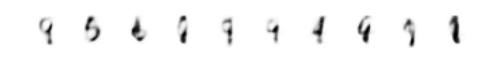

In [181]:
std_dev=2.

n = 1

plt.figure(figsize=(8, 8))
for j in range(10):
    plt.subplot(1, 10, n); n += 1; plt.axis('off')
    _z_sample = std_dev * np.random.rand(latent_dim)
    _c_sample = get_one_hot_vector(j, categorical_dim)
    latent_sample = np.hstack((_z_sample, _c_sample))
    generated = generator.predict(np.array([latent_sample]))
    digit = generated[0].reshape(28, 28)
    plt.imshow(digit)

plt.show()